In [ ]:
#| default_exp center_surround

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import os
from tensorflow.keras import layers

In [ ]:
#| hide
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [ ]:
#| hide
#| export
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.constraints import NonNeg
from flayers.constraints import Positive

from einops import rearrange, repeat, reduce

from fastcore.basics import patch

from flayers.layers import cast_all

In [ ]:
#| hide
from nbdev.showdoc import *

# Gaussian Filter

> Convolution kernel parametrized as a gaussian.

One way of defining the gaussians is taking the function we used for the Gabors, and remove the periodic function:

In [ ]:
#| export
@tf.function
def gaussian_2d_tf(i, # Horizontal domain
                   j, # Vertical domain
                   imean, # Horizontal mean
                   jmean, # Vertical mean
                   sigma_i, # Horizontal width
                   sigma_j, # Vertical width
                   freq, # Frecuency of the filter
                   sigma_theta # Width of the angle?? Rotation of the domain??
                   ):
    i, j, imean, jmean, sigma_i, sigma_j, freq, sigma_theta, PI = cast_all(i, j, imean, jmean, sigma_i, sigma_j, freq, sigma_theta, np.pi)
    sigma_vector = tf.convert_to_tensor([sigma_i, sigma_j])
    # sigma_vector = tf.clip_by_value(sigma_vector, clip_value_min=1e-5, clip_value_max=200)
    cov_matrix = tf.linalg.diag(sigma_vector)**2
    det_cov_matrix = tf.linalg.det(cov_matrix)
    constant = tf.convert_to_tensor((1/(2*PI*tf.sqrt(det_cov_matrix))))
    rotation_matrix = tf.convert_to_tensor([[tf.cos(sigma_theta), -tf.sin(sigma_theta)],
                                            [tf.sin(sigma_theta), tf.cos(sigma_theta)]])
    rotated_covariance = tf.cast(rotation_matrix @ tf.linalg.inv(cov_matrix) @ tf.transpose(rotation_matrix), tf.float32)

    x_r_1 = rotated_covariance[0,0] * i + rotated_covariance[0,1] * j
    y_r_1 = rotated_covariance[1,0] * i + rotated_covariance[1,1] * j

    distance = i * x_r_1 + j * y_r_1

    gabor = constant * tf.exp(-distance/2)

    return gabor

In [ ]:
#| export
@tf.function
def create_gaussian_rot_tf(Nrows, # Number of horizontal pixels
                           Ncols, # Number of vertical pixels
                           imean, # Horizontal mean *(in degrees)*
                           jmean, # Vertical mean *(in degrees)*
                           sigma_i, # Horizontal width *(in degrees)*
                           sigma_j, # Vertical width *(in degrees)*
                           freq, # Frequency
                           rot_theta, # Rotation of the domain??
                           sigma_theta, # Width of the angle?? Rotation of the domain??
                           fs, # Sampling frequency
                           ):
    """
    Creates a rotated Gabor filter with the input parameters.
    """
    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, rot_theta, sigma_theta, fs)
    
    x_max = Nrows/fs
    int_x = Ncols/fs
    int_y = Nrows/fs

    Nrows, Ncols = cast_all(Nrows, Ncols, dtype=tf.int32)
    fot_x = tf.linspace(0.0, int_x, Nrows+1)[:-1]
    fot_y = tf.linspace(0.0, int_y, Ncols+1)[:-1]
    x, y = tf.meshgrid(fot_x, fot_y, indexing='xy')

    x_r = tf.cos(rot_theta) * (x - imean) - tf.sin(rot_theta) * (y - jmean)
    y_r = tf.sin(rot_theta) * (x - imean) + tf.cos(rot_theta) * (y - jmean)

    return gaussian_2d_tf(x_r, y_r, imean = imean, jmean = jmean, sigma_i = sigma_i, sigma_j = sigma_j, freq = freq, sigma_theta = sigma_theta)

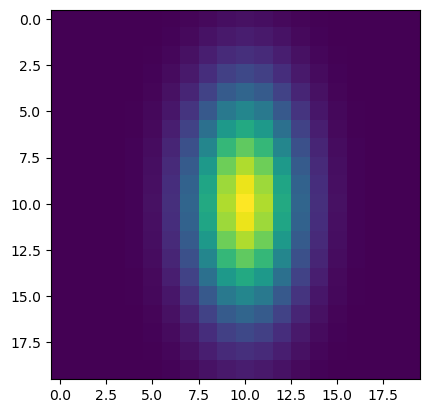

In [ ]:
gabor = create_gaussian_rot_tf(Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=0.1, sigma_j=0.2, freq=10, rot_theta=0, sigma_theta=0, fs=20)
plt.imshow(gabor)
plt.show()

In [ ]:
#| export
@tf.function
def create_multiple_different_rot_gaussian_tf(filters, # Number of Gaussian filters we want to create.
                                              Nrows, # Number of horizontal pixels.
                                              Ncols, # Number of vertical pixels.
                                              imean, # Horizontal mean *(in degrees)*.
                                              jmean, # Vertical mean *(in degrees)*.
                                              sigma_i: list, # Horizontal width *(in degrees)*.
                                              sigma_j: list, # Vertical width *(in degrees)*.
                                              freq: list, # Frequency.
                                              rot_theta: list, # Rotation of the domain??
                                              sigma_theta: list, # Width of the angle?? Rotation of the domain??
                                              fs, # Sampling frequency.
                                              normalize:bool = True, # Wether to normalize (and divide by filters) or not the filters.
                                              ):
    """
    Creates a set of Gaussian filters.
    """
    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, rot_theta, sigma_theta, fs)
    gaussians = tf.TensorArray(dtype = tf.float32, size = filters)

    for n in tf.range(start = 0, limit = filters, dtype = tf.int32):
        gaussians = gaussians.write(n, create_gaussian_rot_tf(Nrows, Ncols, imean, jmean, tf.gather(sigma_i, n), tf.gather(sigma_j, n), tf.gather(freq, n), 
                                                              tf.gather(rot_theta, n), tf.gather(sigma_theta, n), fs))

    gaussians = gaussians.stack()
    ## Normalize the filters
    if normalize: 
        max_per_filter = reduce(gaussians, "filters Ncols Nrows -> filters () ()", "max")
        gaussians = gaussians/(max_per_filter*tf.cast(filters, tf.float32))
    return gaussians

In [ ]:
filters = 4
gaussians = create_multiple_different_rot_gaussian_tf(filters=filters, Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=[0.1, 0.2, 0.1, 0.2], sigma_j=[0.1, 0.1, 0.2, 0.2], freq=[10]*filters,
                                                   rot_theta=[0]*filters, sigma_theta=[0]*filters, fs=20)
gaussians.shape

2022-10-03 10:59:28.550733: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library
2022-10-03 10:59:28.552577: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library
2022-10-03 10:59:28.554296: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at functional_ops.cc:374 : Internal: No function library


TensorShape([4, 20, 20])

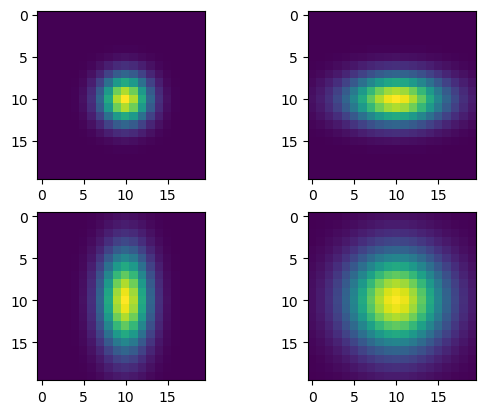

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for gaussian_filter, ax in zip(gaussians, axes.ravel()):
    ax.imshow(gaussian_filter)
plt.show()

# Define them as `Layer`

> Now that we know how to create the filters from the parameters, we can put them into a trainable Keras `Layer`:

In [ ]:
#| export
class GaussianLayer(tf.keras.layers.Layer):
    """
    Pre-initialized Gaussian layer that is trainable through backpropagation.
    """
    def __init__(self,
                 filters, # Number of Gaussian filters.
                 size, # Size of the filters (they will be square).
                 imean, # Horizontal mean *(in degrees)*.
                 jmean, # Vertical mean *(in degrees)*.
                 sigma_i: list, # Horizontal width *(in degrees)*.
                 sigma_j: list, # Vertical width *(in degrees)*.
                 freq: list, # Frequency.
                 rot_theta: list, # Rotation of the domain **(rad)**.
                 sigma_theta: list, # Rotation of the envelope  **(rad)**.
                 fs, # Sampling frequency.,
                 normalize: bool = True, # Wether to normalize the Gabor filters or not.
                 **kwargs, # Arguments to be passed to the base `Layer`.
                 ):
        super(GaussianLayer, self).__init__(**kwargs)

        # if len(sigma_i) != filters: raise ValueError(f"sigma_i has {len(sigma_i)} values but should have {filters} (filters = {filters}).")

        self.filters = filters
        self.size = size
        self.Nrows, self.Ncols = size, size
        self.fs = fs
        self.normalize = normalize

        self._check_parameter_length(sigma_i, sigma_j, freq, rot_theta, sigma_theta)
        self.imean, self.jmean, self.sigma_i, self.sigma_j, self.freq, self.rot_theta, self.sigma_theta = cast_all(imean, jmean, sigma_i, sigma_j, freq, rot_theta, sigma_theta)
        self.logsigma_i, self.logsigma_j = tf.math.log(self.sigma_i), tf.math.log(self.sigma_j)
        
    def build(self, input_shape):

        self.imean = tf.Variable(self.imean, trainable=True, name="imean", constraint=Positive())
        self.jmean = tf.Variable(self.jmean, trainable=True, name="jmean", constraint=Positive())

        # self.sigma_i = tf.Variable(np.random.uniform(0, self.Nrows/self.fs, filters), trainable=True, name="sigma_i")
        self.logsigma_i = tf.Variable(self.logsigma_i, trainable=True, name="logsigma_i")#, constraint=Positive())

        # self.sigma_j = tf.Variable(np.random.uniform(0, self.Ncols/self.fs, filters), trainable=True, name="sigma_j")
        self.logsigma_j = tf.Variable(self.logsigma_j, trainable=True, name="logsigma_j")#, constraint=Positive())

        # self.freq = tf.Variable(np.random.uniform(0, self.fs, filters), trainable=True, name="freq")
        self.freq = tf.Variable(self.freq, trainable=True, name="freq", constraint=Positive())

        # self.rot_theta = tf.Variable(np.random.uniform(0,6, filters), trainable=True, name="rot_theta")
        self.rot_theta = tf.Variable(self.rot_theta, trainable=True, name="rot_theta")

        # self.sigma_theta = tf.Variable(np.random.uniform(0,6, filters), trainable=True, name="sigma_theta")
        self.sigma_theta = tf.Variable(self.sigma_theta, trainable=True, name="sigma_theta")

        self.precalc_filters = tf.Variable(create_multiple_different_rot_gaussian_tf(filters=self.filters, Nrows=self.Nrows, Ncols=self.Ncols, imean=self.imean, jmean=self.jmean, sigma_i=self.sigma_i, sigma_j=self.sigma_j,
                                                                                     freq=self.freq, rot_theta=self.rot_theta, sigma_theta=self.sigma_theta, fs=self.fs, normalize=self.normalize),
                                           trainable=False, name="precalc_filters")

    def _check_parameter_length(self, *args):
        for arg in args:
            if len(arg) != self.filters: raise ValueError(f"Listed parameters should have the same length as filters ({self.filters}).")


In [ ]:
#| export
@patch
def call(self: GaussianLayer, 
         inputs, # Inputs to the layer.
         training=False, # Flag indicating if we are training the layer or using it for inference.
         ):
    """
    Build a set of filters from the stored values and convolve them with the input.
    """
    if training:
         gaussians = create_multiple_different_rot_gaussian_tf(filters=self.filters, Nrows=self.Nrows, Ncols=self.Ncols, imean=self.imean, jmean=self.jmean, sigma_i=tf.math.exp(self.logsigma_i), sigma_j=tf.math.exp(self.logsigma_j),
                                                               freq=self.freq, rot_theta=self.rot_theta, sigma_theta=self.sigma_theta, fs=self.fs, normalize=self.normalize)
         self.precalc_filters.assign(gaussians)
    else:
         gaussians = self.precalc_filters


    ## Keras expects the convolutional filters in shape (size_x, size_y, C_in, C_out)
    gaussians = repeat(gaussians, "filters Ncols Nrows -> Ncols Nrows C_in filters", C_in=inputs.shape[-1])
    
    return tf.nn.conv2d(inputs, gaussians, strides=1, padding="SAME")

It's important to check if we can use it in a model:

In [ ]:
filters = 4
sigma_i = [0.1, 0.2]*2
sigma_j = [0.2, 0.1]*2
freq = [10, 10]*2
rot_theta = [0, 0]*2
sigma_theta = [0, 0]*2

In [ ]:
model = tf.keras.Sequential([
    GaussianLayer(filters=filters, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                  rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20, input_shape=(28,28,1)),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_layer_3 (GaussianLa (None, 28, 28, 4)         1622      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50        
Total params: 1,672
Trainable params: 72
Non-trainable params: 1,600
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


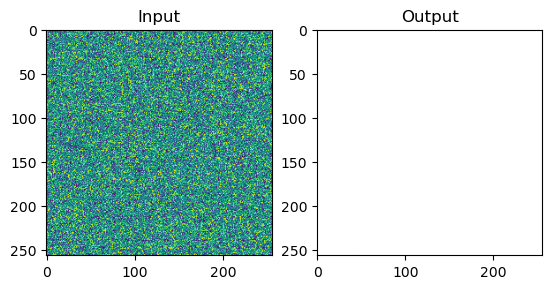

In [ ]:
filters = 4
sigma_i = [0.1, 0.2, 0.3, 0.4]
sigma_j = [0.1, 0.2, 0.3, 0.4]
freq = [10, 20, 30, 40]
theta = [0, 45, 90, 135]
rot_theta = [0, 45, 90, 135]
sigma_theta = [0, 45, 90, 135]

gaussianlayer = GaussianLayer(filters=filters, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                               rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
sample_input = np.random.uniform(0, 1, size=(1, 256, 256, 1))
sample_output = gaussianlayer(sample_input).numpy()
assert sample_input.shape[1:3] == sample_output.shape[1:3]
assert sample_output.shape[-1] == 4
fig, axes = plt.subplots(1,2)
axes[0].imshow(sample_input.squeeze())
axes[1].imshow(sample_output.squeeze())
axes[0].set_title("Input")
axes[1].set_title("Output")
plt.show()

It can be helpful to implement a method to show the Gabor filters that are being used by the layer:

In [ ]:
#| exporti
def find_grid_size(filters):
    ncols = int(np.round(np.sqrt(filters)))
    nrows = ncols
    if ncols*nrows < filters: nrows += 1
    return nrows, ncols

In [ ]:
#| export
@patch
def show_filters(self: GaussianLayer,
                 show: bool = True, # Wether to run plt.plot() or not.
                 ):
    """
    Calculates and plots the filters corresponding to the stored parameters.
    """
    nrows, ncols = find_grid_size(self.filters)
    # gabors = self.filters.numpy()
    
    try: gabors = self.precalc_filters.numpy()
    except: gabors = create_multiple_different_rot_gaussian_tf(filters=self.filters, Nrows=self.Nrows, Ncols=self.Ncols, imean=self.imean, jmean=self.jmean, sigma_i=tf.math.exp(self.logsigma_i), sigma_j=tf.math.exp(self.logsigma_j),
                                                               freq=self.freq, rot_theta=self.rot_theta, sigma_theta=self.sigma_theta, fs=self.fs, normalize=self.normalize)
    fig, axes = plt.subplots(int(nrows), int(ncols), squeeze=False)
    for gabor, ax in zip(gabors, axes.ravel()):
        ax.imshow(gabor)
    if show: plt.show()

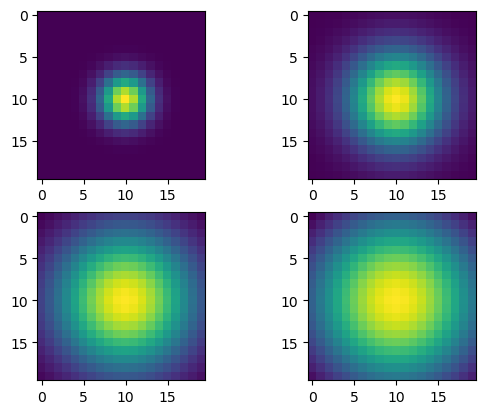

In [ ]:
gaussianlayer = GaussianLayer(filters=filters, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                              rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
gaussianlayer.show_filters()

We can check that the parameters are trainable and thus the gradient is propagated properly:

In [ ]:
gaussianlayer = GaussianLayer(filters=filters, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                           rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
gaussianlayer.build(())
with tf.GradientTape() as tape:
    output = gaussianlayer(sample_input, training=True)
    loss = output - output**2
gradients = tape.gradient(loss, gaussianlayer.trainable_variables)
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=18883578.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=18860230.0>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ -1066228.2, -16377100. , -40864300. , -49804428. ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ -1066296.2, -16376426. , -40863212. , -49803664. ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.00497246, -0.5       ,  4.        ,  0.5       ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0. , 0.5, 3. , 0. ], dtype=float32)>]

## RandomGaussian

> Actually, we can define a different layer that initializes almost all of its parameters randomly by inhereting from `GaussianLayer`.

In [ ]:
#| export
class RandomGaussian(GaussianLayer):
    """
    Randomly initialized Gaussian layer that is trainable through backpropagation.
    """
    def __init__(self,
                 filters, # Number of Gaussian filters.
                 size, # Size of the filters (they will be square).
                 normalize: bool = True, # Wether to normalize the Gaussian filters.
                 **kwargs, # Arguments to be passed to the base `Layer`.
                 ):
        super(GaussianLayer, self).__init__(**kwargs) # Hacky way of using tf.keras.layers.Layer __init__ but maintain GaussianLayer's methods.
        self.filters = filters
        self.size = size
        self.Nrows, self.Ncols = size, size
        self.fs = self.Ncols
        self.normalize = normalize

        self.imean = 0.5
        self.jmean = 0.5
        self.sigma_i = np.random.uniform(0, self.Nrows/self.fs, self.filters)
        self.sigma_j = np.random.uniform(0, self.Ncols/self.fs, self.filters)
        self.freq = np.random.uniform(0, self.fs, self.filters)
        self.theta = np.random.uniform(0,6, self.filters)
        self.rot_theta = np.random.uniform(0,6, self.filters)
        self.sigma_theta = np.random.uniform(0,6, self.filters)

        super(RandomGaussian, self).__init__(self.filters, self.size, self.imean, self.jmean,
                                             self.sigma_i, self.sigma_j, self.freq, self.rot_theta, self.sigma_theta, self.fs, self.normalize)

It's important to check if we can use it in a model:

In [ ]:
model = tf.keras.Sequential([
    RandomGaussian(filters=filters, size=20, input_shape=(28,28,1)),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_gaussian_1 (RandomGau (None, 28, 28, 4)         1622      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                50        
Total params: 1,672
Trainable params: 72
Non-trainable params: 1,600
_________________________________________________________________


We can check that the `.call()` method from `gaussianlayer` still works:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


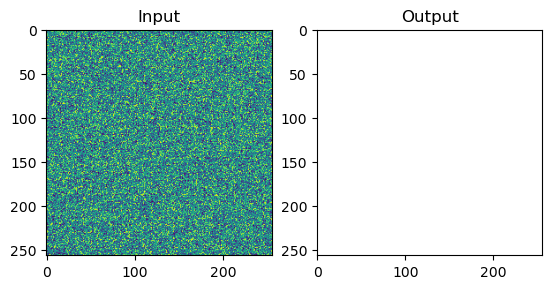

In [ ]:
gaussianlayer = RandomGaussian(filters=4, size=20)
sample_input = np.random.uniform(0, 1, size=(1, 256, 256, 1))
sample_output = gaussianlayer(sample_input).numpy()
assert sample_input.shape[1:3] == sample_output.shape[1:3]
assert sample_output.shape[-1] == 4
fig, axes = plt.subplots(1,2)
axes[0].imshow(sample_input.squeeze())
axes[1].imshow(sample_output.squeeze())
axes[0].set_title("Input")
axes[1].set_title("Output")
plt.show()

Ensure that we can still plot its filters:

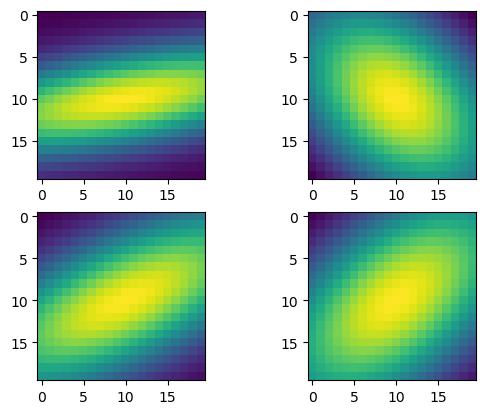

In [ ]:
gaussianlayer = RandomGaussian(filters=4, size=20)
gaussianlayer.show_filters()

We can check that the parameters are trainable and thus the gradient is propagated properly:

In [ ]:
gaussianlayer = RandomGaussian(filters=4, size=20)
with tf.GradientTape() as tape:
    output = gaussianlayer(sample_input, training=True)
    loss = output - output**2
gradients = tape.gradient(loss, gaussianlayer.trainable_variables)
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=29896268.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=26287648.0>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ -6870628.5, -26637878. , -65509092. , -15112732. ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ -9042569., -30340890., -15661477., -69138744.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([ 132928.5   ,   -7520.8125, 2253110.    , 1777672.    ],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ -132928.5,     7522. , -2253113.5, -1777676. ], dtype=float32)>]